In [1]:
#Import the Necessary Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
data = pd.read_csv('spam.csv',encoding='latin-1')

data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":'label', "v2":'text'})
print(data.head())
tags = data["label"]
texts = data["text"]

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


### To do: develop an accurate simple neural network model for spam classification (no LSTM, CNN, etc.)

In [2]:
tags

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: label, Length: 5572, dtype: object

In [3]:
texts

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

In [4]:
#Setting string values to numerical values
data['label_num'] = data['label'].map({'ham':0, 'spam':1})

In [5]:
data.head()

,label,text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


<AxesSubplot:xlabel='label', ylabel='count'>

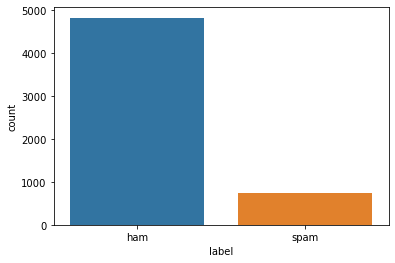

In [6]:
sns.countplot(x=data['label'])

In [7]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Text(0.5, 0, 'Text length')

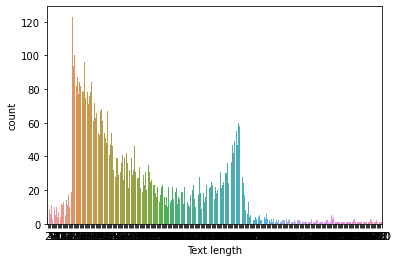

In [8]:
sns.countplot(x=[len(data.loc[i]['text']) for i in range(len(data))])
plt.xlabel('Text length')

In [9]:
#Determining number of words per text, mean of word counts, and total number of words in the dataset
text_word_lengths = [len(data.loc[i]['text'].split()) for i in range(0, len(data))]
text_word_mean = int(np.mean(text_word_lengths))
total_length = np.sum(text_word_lengths)

In [10]:
text_word_lengths[:5], text_word_mean, total_length

([20, 6, 28, 11, 13], 15, 86335)

In [11]:
#Splitting the data
X, y = np.asanyarray(data['text']), np.asanyarray(data['label_num'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
len(X_train), len(X_test), X_train[:2], y_train[:2]

(4457,
 1115,
 array(['Reading gud habit.. Nan bari hudgi yorge pataistha ertini kano:-)',
        'ITS A LAPTOP TAKE IT WITH YOU.'], dtype=object),
 array([0, 0], dtype=int64))

In [12]:
MAXTOKENS = total_length
OUTPUTLEN = text_word_mean

text_vec = layers.TextVectorization(
    max_tokens = MAXTOKENS,
    standardize = 'lower_and_strip_punctuation',
    output_mode = 'int',
    output_sequence_length = OUTPUTLEN
)

text_vec.adapt(X_train)

In [13]:
embedding_layer = layers.Embedding(
    input_dim = MAXTOKENS,
    output_dim = 128,
    embeddings_initializer = 'uniform',
    input_length = OUTPUTLEN
)

In [14]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(input_layer, output_layer)

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
history = model.fit(X_train,
           y_train,
           epochs=5,
           validation_data=(X_test, y_test),
           validation_steps=int(0.2 * len(X_test)))

Epoch 1/5
140/140 [==============================] - 26s 182ms/step - loss: 0.3251 - accuracy: 0.8979 - val_loss: 0.1198 - val_accuracy: 0.9677
Epoch 2/5
140/140 [==============================] - 22s 159ms/step - loss: 0.0750 - accuracy: 0.9807 - val_loss: 0.0674 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 21s 151ms/step - loss: 0.0319 - accuracy: 0.9917 - val_loss: 0.0632 - val_accuracy: 0.9803
Epoch 4/5
140/140 [==============================] - 22s 154ms/step - loss: 0.0173 - accuracy: 0.9962 - val_loss: 0.0654 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 22s 155ms/step - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.0679 - val_accuracy: 0.9803


In [17]:
_, accuracy = model.evaluate(X_train, y_train)

140/140 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9987


In [18]:
spam_ham= ['spam' if x > 0.1 else 'ham' for x in data['label_num']]
output_csv = pd.DataFrame(spam_ham, columns = ['label']).to_csv('Cruz_spam_output.csv')